# DL in NLP

## Task 2: Classifying TED talks

Sergei Volodin, senior undergraduate student at MIPT

In [1]:
%matplotlib inline
import tensorflow as tf
import json
import numpy as np
import pandas as pd
import collections
from __future__ import print_function
import re
import random
import math
from sklearn.manifold import TSNE
from matplotlib import pylab
from transliterate import translit
from six.moves import range
import sklearn.metrics
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
from tqdm import tqdm

In [2]:
def print_unicode(ent):
    print(repr(ent).decode("unicode-escape"))

In [3]:
filename = 'ted_ru-20160408.json'
data_test = json.loads(open(filename + '.test', 'r').read(), 'unicode-escape')
data_train = json.loads(open(filename + '.train', 'r').read(), 'unicode-escape')

Plan:

1. Removing non-letters
2. Obtaining words, training word2vec CBOW model
3. Running RNN on document
4. Classifying based on final output

# Building dictionary

In [4]:
vocabulary_size = 100000
embedding_size = 256
context_size = 4
words_regex = re.compile(ur'[^а-яА-ЯёЁa-zA-Z]')

def str_to_words(s):
    return(words_regex.sub(' ', s).lower().split())

def data_to_str(data):
    return(' '.join(map(lambda x : x['content'], data_train)))

def build_dataset(words, vocabulary_size):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    return data, count, dictionary

In [5]:
all_text = data_to_str(data_train)# + data_to_str(data_test)
words = str_to_words(all_text)
data, count, dictionary = build_dataset(words, vocabulary_size)

In [6]:
print_unicode(count[:5])
print_unicode(data[:10])

[['UNK', 50679], (u'и', 92090), (u'в', 83510), (u'что', 57304), (u'я', 47139)]
[4, 49, 42333, 12866, 7686, 21, 4461, 740, 105, 31181]


# Pretraining CBOW word2vec embeddings

In [7]:
data_index = 0

def to_range(n):
    return(n % len(data))

# CBOW model
def generate_batch(batch_size, context_size):
    global data_index
  
    data_index = to_range(data_index)
    
    batch = np.ndarray(shape=(batch_size, context_size * 2), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    for i in range(batch_size):
        labels[i] = data[data_index]
        for j in range(0, context_size):
            batch[i][2 * j] = data[to_range(data_index - (j + 1))]
            batch[i][2 * j + 1] = data[to_range(data_index + (j + 1))]
        data_index = to_range(data_index + 1)
        
    return batch, labels

In [30]:
batch_size = 128
num_sampled = 256
graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, context_size * 2], name = "train_dataset")
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1], name = "train_labels")
  
    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name = "embeddings")
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)), name = "SM_weights")
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]), name = "SM_biases")
    
    embed = tf.reduce_mean(tf.nn.embedding_lookup(embeddings, train_dataset), [1], name = "emb_result")
    loss = tf.reduce_mean(
      tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size), name = "loss")

  
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    
    tf.summary.scalar("Embedding_loss", loss)
    summary_emb = tf.summary.merge_all()

In [77]:
logs_path = '~/tensorboard/05'

In [33]:
writer = tf.summary.FileWriter(logs_path, graph=graph)
epochs = 30000
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for epoch in tqdm(range(epochs)):
        batch_data, batch_labels = generate_batch(batch_size, context_size)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l, summary = session.run([optimizer, loss, summary_emb], feed_dict = feed_dict)
        writer.add_summary(summary, epoch)
    final_embeddings = normalized_embeddings.eval()

100%|██████████| 30000/30000 [10:40<00:00, 46.87it/s]


In [8]:
emb_fn = "emb.pkl"
#pickle.dump(final_embeddings, open(emb_fn, 'w'))
final_embeddings = pickle.load(open(emb_fn, 'r'))

# Preparing dataset

In [9]:
pad_word = vocabulary_size
max_words = 5600
num_classes = 8
num_steps = 30

In [10]:
def str_to_idx(s):
    words = str_to_words(s)
    res = []
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
        res.append(index)
    return(res)
def get_Y(data):
    classes = map(lambda x: x['class'] - 1, data_train)
    return(np.array(classes))
def get_X(data):
    X = map(lambda x : str_to_idx(x['content']), data)
    L = map(len, X)
    return np.array(X), np.array(L)

In [12]:
X, L = get_X(data_train)

In [13]:
Y = get_Y(data_train)

In [14]:
Xtest, Ltest = get_X(data_test)

In [15]:
del dictionary, data, count, all_text, words

# Word length distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4abfbbfd0>]], dtype=object)

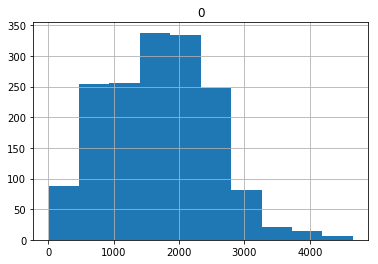

In [69]:
pd.DataFrame(L).hist()
plt.title('Train set length')

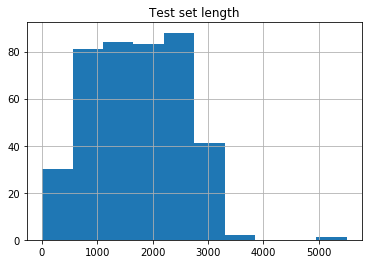

In [75]:
pd.DataFrame(Ltest).hist()
plt.title('Test set length')

# RNN classifier

In [63]:
logs_path = '~/tensorboard/cl/03'
batch_size = 64
lstm_size = 128
c_graph = tf.Graph()
with c_graph.as_default():
    text_input = tf.placeholder(tf.int32, shape=[None, None])
    text_length = tf.placeholder(tf.float32, shape=[None])
    ans_input = tf.placeholder(tf.int32, shape=[None])
    keep_prob = tf.placeholder(tf.float32)
    cell_state = tf.placeholder(tf.float32, [batch_size, lstm_size])
    hidden_state = tf.placeholder(tf.float32, [batch_size, lstm_size])
    initial_state = tf.contrib.rnn.LSTMStateTuple(cell_state, hidden_state)
    
    labels = tf.one_hot(ans_input, num_classes)
    
    emb_words   = tf.Variable(final_embeddings, name = "embeddings", trainable = True, dtype = tf.float32)
    emb_padding = tf.Variable(1. * np.zeros((1, embedding_size)), trainable = False, dtype = tf.float32)
    embeddings = tf.concat([emb_words, emb_padding], 0)
    
    word_vectors = tf.reshape(tf.nn.embedding_lookup(embeddings, text_input), [-1, num_steps, embedding_size])
    word_list = tf.unstack(tf.nn.dropout(word_vectors, keep_prob), axis = 1)
    
    # LSTM
    cell = tf.contrib.rnn.LSTMCell(num_units = lstm_size)
    _, current_state = tf.contrib.rnn.static_rnn(cell, word_list, initial_state = initial_state,
                                               sequence_length = text_length)
    out = current_state[1]
    # /LSTM
    
    dense = tf.nn.dropout(tf.layers.dense(inputs = out, units=64, activation=tf.nn.relu), keep_prob)
    logits = tf.contrib.layers.fully_connected(dense, num_classes, activation_fn = None)
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels, logits = logits))
    optimizer = tf.train.RMSPropOptimizer(0.2).minimize(loss)
    
    tf.summary.scalar("Classification_loss", loss)
    summary = tf.summary.merge_all()
    
    answer = tf.argmax(logits, 1)
    probability = tf.nn.softmax(logits)
    
    initializer = tf.global_variables_initializer()
    writer = tf.summary.FileWriter(logs_path, c_graph)

In [66]:
def get_minibatch(X, Y, L, size = batch_size):
    N = len(X)
    start_idx = 0
    while start_idx < N:
        do_clear_state = 1
        idx = range(start_idx, start_idx + size)
        if np.max(idx) >= N:
            break
        max_len = np.max(L[idx])
        start_pos = 0
        while start_pos < max_len:
            X_ = []
            L_ = []
            for i in idx:
                v = X[i][start_pos : min(start_pos + num_steps, L[i])]
                L_.append(len(v))
                v += [pad_word] * (num_steps - len(v))
                X_.append(v)
            yield np.array(X_), Y[idx], np.array(L_), do_clear_state
            do_clear_state = 0
            start_pos += num_steps
        start_idx += size

In [65]:
c_sess = tf.Session(graph=c_graph)
c_sess.run(initializer)
rolling_epoch = 0
_current_cell_state = np.zeros((batch_size, lstm_size))
_current_hidden_state = np.zeros((batch_size, lstm_size))

In [ ]:
for X_, Y_, L_, do_clear_state in get_minibatch(X, Y, L, batch_size):
    feed_dict = {text_input: X_, ans_input: Y_, text_length: L_,
                 cell_state: _current_cell_state, hidden_state: _current_hidden_state, keep_prob: 0.5}
    _, l, s, c_state = c_sess.run([optimizer, loss, summary, current_state], feed_dict = feed_dict)
    _current_cell_state, _current_hidden_state = c_state
    writer.add_summary(s, rolling_epoch)
    rolling_epoch += 1
    print(rolling_epoch, l, do_clear_state)

3126 1.37552 1
3127 1.19969 0
3128 1.17041 0
3129 1.72624 0
3130 1.42883 0
3131 1.18279 0
3132 1.14935 0
3133 1.13477 0
3134 1.16912 0
3135 1.61738 0
3136 1.19307 0
3137 1.46071 0
3138 1.20135 0
3139 1.37603 0
3140 1.13314 0
3141 1.15031 0
3142 1.26538 0
3143 1.13442 0
3144 1.15111 0
3145 1.57539 0
3146 1.14686 0
3147 1.15137 0
3148 1.3005 0
3149 1.14612 0
3150 1.13509 0
3151 1.13392 0
3152 1.14619 0
3153 1.14702 0
3154 1.14815 0
3155 1.14929 0
3156 1.14989 0
3157 1.14095 0
3158 1.15138 0
3159 1.14855 0
3160 1.1339 0
3161 1.14295 0
3162 1.19986 0
3163 1.13098 0
3164 1.1428 0
3165 1.14347 0
3166 1.36436 0
3167 1.14174 0
3168 1.1463 0
3169 1.14965 0
3170 1.15219 0
3171 1.15337 0
3172 1.14881 0
3173 1.36307 0
3174 1.14911 0
3175 1.14855 0
3176 1.14431 0
3177 1.37737 0
3178 1.14206 0
3179 1.13724 0
3180 1.13005 0
3181 1.1405 0
3182 1.14953 0
3183 1.14055 0
3184 1.14108 0
3185 1.14259 0
3186 1.16159 0
3187 1.15132 0
3188 1.15356 0
3189 1.15216 0
3190 1.14841 0
3191 1.14685 0
3192 1.13551 0


3676 1.49037 0
3677 1.49307 0
3678 1.48185 0
3679 1.49026 0
3680 1.48826 0
3681 1.61006 0
3682 1.47635 0
3683 1.71674 0
3684 1.50753 0
3685 1.47592 0
3686 2.11658 0
3687 1.50196 0
3688 1.49205 0
3689 1.49943 0
3690 1.5316 0
3691 1.47616 0
3692 1.48911 0
3693 1.48754 0
3694 1.46742 0
3695 1.48703 0
3696 1.91837 0
3697 1.49056 0
3698 1.49138 0
3699 1.48038 0
3700 1.48125 0
3701 1.53299 0
3702 1.49168 0
3703 1.49125 0
3704 1.88633 0
3705 1.49234 0
3706 1.48261 0
3707 1.49372 0
3708 1.48428 0
3709 1.50197 0
3710 1.48171 0
3711 1.49239 0
3712 1.48295 0
3713 1.47805 0
3714 1.47735 0
3715 1.62672 0
3716 1.78956 0
3717 1.49299 0
3718 1.49404 0
3719 1.49372 0
3720 1.49288 0
3721 1.46577 0
3722 1.47623 0
3723 1.48894 0
3724 1.48976 0
3725 1.49084 0
3726 1.48234 0
3727 1.51703 0
3728 1.49036 0
3729 1.6184 0
3730 1.47827 0
3731 1.49233 0
3732 1.48408 0
3733 1.49697 0
3734 1.49445 0
3735 1.47904 0
3736 1.48831 0
3737 1.47591 0
3738 1.476 0
3739 1.47625 0
3740 1.48751 0
3741 1.47597 0
3742 1.47673 0

4226 1.43727 0
4227 1.43633 0
4228 1.44666 0
4229 1.43534 0
4230 1.43197 0
4231 1.43014 0
4232 1.44086 0
4233 1.44026 0
4234 1.42849 0
4235 1.43822 0
4236 1.43843 0
4237 1.4294 0
4238 1.43057 0
4239 1.44142 0
4240 1.41967 0
4241 1.43027 0
4242 1.44446 0
4243 1.43913 0
4244 1.45147 0
4245 1.43902 0
4246 1.43318 0
4247 1.43029 0
4248 1.42893 0
4249 1.4381 0
4250 1.43804 0
4251 1.42836 0
4252 1.42864 0
4253 1.42925 0
4254 1.44225 0
4255 1.43593 0
4256 1.44979 0
4257 1.43974 0
4258 1.43454 0
4259 1.44051 0
4260 1.42815 0
4261 1.43777 0
4262 1.42696 0
4263 1.43732 0
4264 1.43732 0
4265 1.43732 0
4266 1.43732 0
4267 1.42704 0
4268 1.42741 0
4269 1.43837 0
4270 1.4413 0
4271 1.53897 0
4272 1.46575 0
4273 1.45451 0
4274 1.43205 0
4275 1.42911 0
4276 1.42801 0
4277 1.43759 0
4278 1.42687 0
4279 1.43736 0
4280 1.43737 0
4281 1.4374 0
4282 1.43747 0
4283 1.42691 0
4284 1.427 0
4285 1.43833 0
4286 1.44076 0
4287 1.43542 0
4288 1.44524 0
4289 1.45994 0
4290 1.45013 0
4291 1.42269 1
4292 1.40067 0
4

4775 1.28021 0
4776 1.28736 0
4777 1.28564 0
4778 1.35344 0
4779 2.49935 0
4780 1.28253 0
4781 1.28039 0
4782 1.2773 0
4783 1.27588 0
4784 1.27465 0
4785 1.35339 0
4786 1.27554 0
4787 1.26833 0
4788 1.27704 0
4789 1.27297 0
4790 1.27666 0
4791 1.27594 0
4792 1.27493 0
4793 1.2747 0
4794 1.27434 0
4795 1.27451 0
4796 1.27453 0
4797 1.27506 0
4798 1.27531 0
4799 1.27604 0
4800 1.27612 0
4801 1.27661 0
4802 1.27617 0
4803 1.2762 0
4804 1.29069 0
4805 1.27395 0
4806 1.27389 0
4807 1.27433 0
4808 1.27464 0
4809 1.27544 0
4810 1.27579 0
4811 1.27653 0
4812 1.29336 0
4813 1.27434 0
4814 1.27443 0
4815 1.27502 0
4816 1.27528 0
4817 1.27598 0
4818 1.27601 0
4819 1.27641 0
4820 1.27597 0
4821 1.27598 0
4822 1.27535 0
4823 1.27529 0
4824 1.27481 0
4825 1.27488 0
4826 1.27465 0
4827 1.27492 0
4828 1.27486 0
4829 1.27528 0
4830 1.27525 0
4831 1.27567 0
4832 1.2755 0
4833 1.27577 0
4834 1.27542 0
4835 1.27555 0
4836 1.27515 0
4837 1.27525 0
4838 1.27492 0
4839 1.2751 0
4840 1.27488 0
4841 1.27515 0


5326 1.33333 0
5327 1.33339 0
5328 1.33376 0
5329 1.33402 0
5330 1.33452 0
5331 1.33469 0
5332 1.33499 0
5333 1.33482 0
5334 1.33479 0
5335 1.33439 0
5336 1.33425 0
5337 1.33389 0
5338 1.33386 0
5339 1.33368 0
5340 1.33382 0
5341 1.33381 0
5342 1.33407 0
5343 1.33412 0
5344 1.3344 0
5345 1.33438 0
5346 1.33455 0
5347 1.33438 0
5348 1.33442 0
5349 1.33417 0
5350 1.33418 0
5351 1.33397 0
5352 1.33403 0
5353 1.3339 0
5354 1.33404 0
5355 1.33398 0
5356 1.33417 0
5357 1.33412 0
5358 1.33431 0
5359 1.53847 1
5360 1.60523 0
5361 1.634 0
5362 1.50396 0
5363 1.49841 0
5364 1.49314 0
5365 1.54603 0
5366 1.47283 0
5367 1.46835 0
5368 1.47729 0
5369 1.46067 0
5370 1.45295 0
5371 1.45816 0
5372 1.84521 0
5373 1.87466 0
5374 1.54108 0
5375 1.44338 0
5376 2.05639 0
5377 1.43747 0
5378 1.80739 0
5379 1.43869 0
5380 1.43998 0
5381 1.62817 0
5382 1.79428 0
5383 1.43133 0
5384 1.42896 0
5385 1.60592 0
5386 1.42875 0
5387 1.41715 0
5388 1.5377 0
5389 1.42591 0
5390 1.4203 0
5391 1.42542 0
5392 1.74463 0
5

# Classifying test data

In [102]:
def classify_idx(X, L, idx):
    start_pos = 0
    max_len = np.max(L[idx])
    _current_cell_state = np.zeros((batch_size, lstm_size))
    _current_hidden_state = np.zeros((batch_size, lstm_size))
    res = np.zeros((batch_size, num_classes))
    while start_pos < max_len:
        print(start_pos)
        X_ = []
        L_ = []
        
        for i in idx:
            v = X[i][start_pos : min(start_pos + num_steps, L[i])]
            L_.append(len(v))
            v += [pad_word] * (num_steps - len(v))
            X_.append(v)
    
        feed_dict = {text_input: X_, text_length: L_, cell_state: _current_cell_state,
                     hidden_state: _current_hidden_state, keep_prob: 1}
        ll, c_state = c_sess.run([logits, current_state], feed_dict = feed_dict)
        _current_cell_state, _current_hidden_state = c_state
        res += ll
        
        start_pos += num_steps
    print(ll)
    answers = np.argmax(ll, axis = 1)
    return(answers)

In [103]:
classify_idx(X, L, range(1000,1000+64))

0
30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720
750
780
810
840
870
900
930
960
990
1020
1050
1080
1110
1140
1170
1200
1230
1260
1290
1320
1350
1380
1410
1440
1470
1500
1530
1560
1590
1620
1650
1680
1710
1740
1770
1800
1830
1860
1890
1920
1950
1980
2010
2040
2070
2100
2130
2160
2190
2220
2250
2280
2310
2340
2370
2400
2430
2460
2490
2520
2550
2580
2610
2640
2670
2700
2730
2760
2790
2820
2850
2880
2910
2940
2970
3000
3030
3060
3090
3120
3150
3180
3210
3240
3270
3300
3330
3360
3390
3420
3450
3480
3510
3540
3570
3600
3630
3660
3690
3720
3750
3780
3810
3840
3870
3900
3930
3960
3990
4020
4050
4080
4110
4140
4170
4200
4230
4260
4290
[[-15.02104855 -16.76411057 -17.23412132 -17.45726013 -17.7449398
  -17.45726013 -18.84355164 -18.84355164]
 [-15.02104855 -16.76411057 -17.23412132 -17.45726013 -17.7449398
  -17.45726013 -18.84355164 -18.84355164]
 [-15.02104855 -16.76411057 -17.23412132 -17.45726013 -17.7449398
  -17.45726013 -18.84355164 -18.84355

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [104]:
Y[range(1000,1000+64)]

array([0, 0, 1, 4, 0, 0, 0, 3, 0, 0, 0, 5, 0, 0, 0, 2, 7, 4, 0, 0, 3, 1, 0,
       1, 3, 0, 0, 2, 0, 0, 5, 0, 0, 1, 0, 0, 1, 2, 2, 0, 0, 0, 0, 1, 0, 0,
       7, 2, 0, 0, 3, 2, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 3, 0])